In [318]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from collections import defaultdict
from pathlib import Path

import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer


In [129]:
import sys 
#!{sys.executable} -m pip install git+https://github.com/textpipe/textpipe.git


* [1. Data Pre-Processing](#DPP)
    
    * [1.1. Renaming txt Files](#rename)

    * [1.2. Extracting Data](#extract)
    
    * [1.3. Clearing MetaData](#ClearMD)
    
* [2. Creating a Baseline](#Baseline)

<a class="anchor" id="DPP">

## 1. Data Preprocessing



<a class="anchor" id="rename">

### 1.1. Renaming .txt Files


In [136]:
#Changing the names of the .txt files so there's no duplicates

def change_file_name(author):
    i = 0
    my_dir_path = "Data/Corpora/train/" + author
    
    for filename in os.listdir(my_dir_path): 
        
        #Define the new and old names with directory path
        new_name =str(author) + str(i) + ".txt"
        old_name = my_dir_path + '/' + filename 
        new_name = my_dir_path + '/' + new_name 
        
        #So it doesn't give out an error when it runs for the second time
        # rename all the files 
        if new_name != old_name: #IT STILL GIVES OUT ERROR
            os.rename(old_name, new_name) 
        i += 1

In [ ]:
authors = ['AlmadaNegreiros','CamiloCasteloBranco','EcaDeQueiros','JoseRodriguesSantos','JoseSaramago','LuisaMarquesSilva']
authors_sigla = ['AN','CCB','EQ','JRS','JS','LMS']

#### ONLY RUN ONCE IF ORIGINAL FILE NAMES otherwise it will give an error

In [264]:
#for a in range(len(authors)):
#    change_file_name(authors[a])

<a class="anchor" id="extract">

### 1.2. Extracting Data

In [261]:
#Create a df for one author the respective .txt files in the corpora
def create_df_from_txt(author):
    my_dir_path = "Data/Corpora/train/" + author

    results = defaultdict(list)
    for file in Path(my_dir_path).iterdir():
        with open(file, "r",encoding = 'utf8') as file_open:
            results["id"].append(file.name)
            results["text"].append(file_open.read())
            results["author"] = author
            file_open.close()
    df = pd.DataFrame(results)
    
    return df

In [262]:
#Join together the dataframes from all the authors
def join_df(authors):

    df = pd.DataFrame()
    for a in range(len(authors)):
        df = df.append(create_df_from_txt(authors[a]))
    df.reset_index(inplace = True, drop = True)    
    return df 

In [286]:
### Running all the functions

#Creating the training data frame
traindf = join_df(authors)

#Replacing the name of the authors with labels of their initials
for i in range(0,len(authors)):
    traindf.author = traindf.author.replace(authors[i],authors_sigla[i])
traindf

,id,text,author
0,AlmadaNegreiros0.txt,Title: A Scena do Odio\n\nAuthor: José de Alma...,AN
1,AlmadaNegreiros1.txt,Title: O Jardim da Pierrette\n\nAuthor: José d...,AN
2,AlmadaNegreiros2.txt,\n\nTitle: A Invenção do Dia Claro\n\nAuthor: ...,AN
3,AlmadaNegreiros3.txt,\nTitle: Litoral\n A Amadeo de Souza Car...,AN
4,AlmadaNegreiros4.txt,\n\n\nEXPOSIÇÃO\n\n+amadeo\nde souza\ncardoso+...,AN
...,...,...,...
58,LuisaMarquesSilva4.txt,Título\ne-medo\n\nAutora (inspiradíssima)\nLuí...,LMS
59,LuisaMarquesSilva5.txt,"LISBOA 2050\nLisboa, ano de 2050. Um Agosto tã...",LMS
60,LuisaMarquesSilva6.txt,Título\nUm passeio pelo inferno\n\nAutora\nLuí...,LMS
61,LuisaMarquesSilva7.txt,Título\nRapsódia sem dó (maior)\n\nAutora\nLuí...,LMS


<a class="anchor" id="clearMD">

### 1.2. Clearing MetaData
</a>

The majority of the .txt files have metadata at the beginning. This is unnecessary and may introduce noise in our model, as such it may be a good idea to remove it. 

In [266]:
import spacy

Testing with just one of the .txt:

In [267]:
test = traindf.iloc[0:1]
test

,id,text,author
0,AlmadaNegreiros0.txt,Title: A Scena do Odio\n\nAuthor: José de Alma...,AN


In [268]:
def set_custom_boundaries(doc):
    # Adds support to use '\n\n\n' as the delimiter for sentence detection
    for token in doc[:-1]:
        if token.text == '\n\n\n':
            doc[token.i+1].is_sent_start = True
    return doc


nlp = spacy.load('en_core_web_sm',disable=["parser"])
nlp.add_pipe(set_custom_boundaries)
custom_sentences = nlp(test.iloc[0,1])
custom_sentences = list(custom_sentences.sents)

i=0
for sentence in custom_sentences:
    print('**SPACE', i, '**', sentence)
    i +=1
#nlp_pt = spacy.load('pt_core_news_sm')

**SPACE 0 ** Title: A Scena do Odio

Author: José de Almada Negreiros

Release Date: September 16, 2007 [EBook #22615]

Language: Portuguese




A ALVARO DE CAMPOS

_Excerptos de um poema desbaratado
que foi escripto durante os
três dias e as três noites que durou
a revolução de 14 de Maio de 1915._



**SPACE 1 ** Satanizo-Me Tara na Vara de Moysés!
O castigo das serpentes é-Me riso nos dentes,
Inferno a arder o Meu cantar!
Sou Vermelho-Niagára dos sexos escancarados nos chicotes dos cossacos!
Sou Pan-Demonio-Trifauce enfermiço de Gula!
Sou Genio de Zarathustra em Taças de Maré-Alta!
Sou Raiva de Medusa e Damnação do Sol!

Ladram-Me a Vida por vivê-La
e só me deram Uma!
Hão-de lati-La por sina!
agora quero vivê-La!
Hei-de Poeta cantá-La em Gala sonora e dina!
Hei-de Gloria desannuviá-La!
Hei-de Guindaste içá-La Esfinge
da Valla commum onde Me querem rir!
Hei-de trovão-clarim levá-La Luz
ás Almas-Noites do Jardim das Lagrymas!
Hei-de bombo rufá-La pompa de Pompeia
nos Funeraes de Mim!


In [272]:
text_nometa = custom_sentences[1]

In [ ]:
#WIP.... 
#Works for a few of the .txt files if the meta data is just at the beginning but not if there are too many large spaces (/n/n/n) or if there are spaces between the text

<a class="anchor" id="Baseline">

## 2. Creating a Baseline
    
</a>

Our goal now is to create a naíve baseline to compare our model with. It won't involve any pre-processing of data or removal of extra meta data.

1st Try: Using DummyClassifier as a baseline? 

In [273]:
import numpy as np
from sklearn.dummy import DummyClassifier

In [292]:
X = traindf.loc[:,'text']
y = traindf.loc[:,'author']
dummy_clf = DummyClassifier(strategy="most_frequent") #stratified
dummy_clf.fit(X, y)
dummy_clf.predict(X)


array(['CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB',
       'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB',
       'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB',
       'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB',
       'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB',
       'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB',
       'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB', 'CCB'],
      dtype='<U3')

In [275]:
dummy_clf.score(X, y)

0.31746031746031744

Too stupid of a baseline? 

## Choosing Evaluation Metrics

Can we use Accuracy as an evaluation metric? Depends if the dataset is unbalanced. Let's check:

In [291]:
traindf.loc[:,'author'].value_counts()

CCB    20
JS     12
LMS     9
AN      9
JRS     8
EQ      5
Name: author, dtype: int64

It is unbalanced in favour of Camilo Castelo Branco which is why we get a higher accuracy when we use the DummyClassifier with most frequent strategy (0.31) compared to other strategies (stratified 0.22) even though it's just classifying all texts as belonging to CCB. As such accuracy may not be the best metric in this case.

## Word Cloud

To see a word cloud - or the most frequent words - written by a given author just type in the function one of the following siglas: 


In [277]:
authors_sigla

['AN', 'CCB', 'EQ', 'JRS', 'JS', 'LMS']

Corresponding to the following authors:

In [278]:
authors

['AlmadaNegreiros',
 'CamiloCasteloBranco',
 'EcaDeQueiros',
 'JoseRodriguesSantos',
 'JoseSaramago',
 'LuisaMarquesSilva']

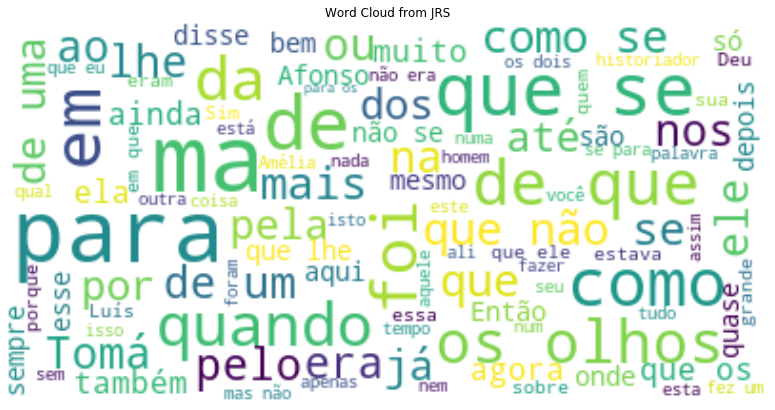

In [290]:
def word_cloud(author):
    
    data = " ".join(traindf[traindf.author == author]['text'])

    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data)
    # Display the generated image:
    plt.figure(figsize=(17,7))
    plt.title('Word Cloud from ' + author)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


word_cloud('JRS')

WILL NEED TO REMOVE STOP WORDS FIRST BEFORE IT MAKES ANY SENSE 

In [287]:
traindf

,id,text,author
0,AlmadaNegreiros0.txt,Title: A Scena do Odio\n\nAuthor: José de Alma...,AN
1,AlmadaNegreiros1.txt,Title: O Jardim da Pierrette\n\nAuthor: José d...,AN
2,AlmadaNegreiros2.txt,\n\nTitle: A Invenção do Dia Claro\n\nAuthor: ...,AN
3,AlmadaNegreiros3.txt,\nTitle: Litoral\n A Amadeo de Souza Car...,AN
4,AlmadaNegreiros4.txt,\n\n\nEXPOSIÇÃO\n\n+amadeo\nde souza\ncardoso+...,AN
...,...,...,...
58,LuisaMarquesSilva4.txt,Título\ne-medo\n\nAutora (inspiradíssima)\nLuí...,LMS
59,LuisaMarquesSilva5.txt,"LISBOA 2050\nLisboa, ano de 2050. Um Agosto tã...",LMS
60,LuisaMarquesSilva6.txt,Título\nUm passeio pelo inferno\n\nAutora\nLuí...,LMS
61,LuisaMarquesSilva7.txt,Título\nRapsódia sem dó (maior)\n\nAutora\nLuí...,LMS


## Testing the Importance of Punctuation

We know that José Saramago has an interesting use of punctuation and it can be a factor in identifying texts from him. Does this mean that we shouldn't consider punctuations as stop-words? Let's test it.

To do so we will use a dummy classifier on two texts from Saramago and two from JRS. Will we see a difference in the performance of the classiier with or without punctuation?

In [303]:
punc_traindf = traindf[traindf.author=='JS'][1:3].append(traindf[traindf.author=='JRS'][1:3])
punc_traindf 

,id,text,author
43,JoseSaramago1.txt,José Saramago As intermitências da morte\nComp...,JS
44,JoseSaramago10.txt,José Saramago\n\nTerra do Pecado\n\nAviso\nO a...,JS
35,JoseRodriguesSantos1.txt,José Rodrigues dos Santos A FÓRMULA DE DEUS\n\...,JRS
36,JoseRodriguesSantos2.txt,A MÃO DO D I A B O r o m a n c e\n\n\n\nNós so...,JRS


In [316]:
X = punc_traindf.loc[:,'text']
y = punc_traindf.loc[:,'author']
pdummy_clf = DummyClassifier(strategy="stratified") #stratified, most_frequent
pdummy_clf.fit(X, y)
pdummy_clf.predict(X)


array(['JS', 'JRS', 'JRS', 'JS'], dtype=object)

In [317]:
dummy_clf.score(X, y)

0.25

Removing the punctuation:

In [325]:
X

43    José Saramago As intermitências da morte\nComp...
44    José Saramago\n\nTerra do Pecado\n\nAviso\nO a...
35    José Rodrigues dos Santos A FÓRMULA DE DEUS\n\...
36    A MÃO DO D I A B O r o m a n c e\n\n\n\nNós so...
Name: text, dtype: object

In [319]:
tokenizer = RegexpTokenizer(r'\w+')

result = tokenizer.tokenize(X)

print(result)

TypeError: expected string or bytes-like object